<a href="https://colab.research.google.com/github/19PA1A0465/AI-LAB/blob/master/Recurrent_Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [5]:
pip install pandarallel


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import numpy as np
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, use_memory_fs=False, )
import spacy
#import en_core_web_md
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## Read Data

In [8]:
data = pd.read_csv('/content/drive/MyDrive/FakeReviewClassification/data/combined_news_data_processed.csv')
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74011 entries, 0 to 74011
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   74011 non-null  object
 1   text    74011 non-null  object
 2   label   74011 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.3+ MB


In [9]:
data

,title,text,label
0,"As U.S. budget fight looms, Republicans flip t...",washington reuters head conservative republica...,1
1,U.S. military to accept transgender recruits o...,washington reuters transgender people allow ti...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,washington reuters special counsel investigati...,1
3,FBI Russia probe helped by Australian diplomat...,washington reuters trump campaign adviser geor...,1
4,Trump wants Postal Service to charge 'much mor...,seattle washington reuters president donald tr...,1
...,...,...,...
74007,Study: Trump On Track to Be Most Mocked Presid...,new york ap stephen colbert crude reference do...,1
74008,Trump Hiring Freeze Not Shutting Down Army Chi...,president donald trump s civilian hire freeze ...,1
74009,ESPN’s Jeremy Schaap: No ’Evidence’ Kaepernick...,thursday espn s jeremy schaap weigh quarterbac...,1
74010,Dem Rep Waters: Trump Making Foreign Policy De...,saturday msnbc s joy rep maxine waters weigh p...,1


## Exploratory Data Analysis

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


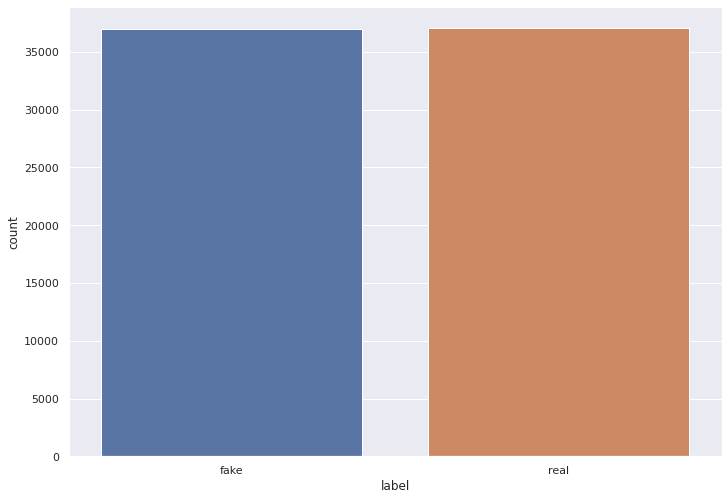

In [10]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
conversion_dict = {0: 'real', 1: 'fake'}
sns.countplot(data['label'].apply(lambda x: conversion_dict[x]))

In [11]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
data['length'] = data['text'].apply(lambda x: len(x.split(' ')))

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:2857: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  pct = percentile_func(x, rng, axis=axis, interpolation=interpolation,


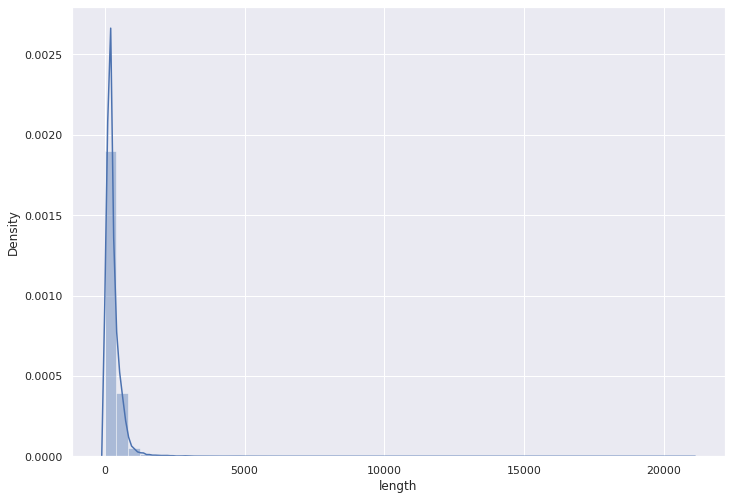

In [12]:
sns.distplot(data['length'])

In [13]:
data['length'].describe()

count    74011.000000
mean       296.429044
std        332.451560
min          1.000000
25%        130.000000
50%        222.000000
75%        367.000000
max      21011.000000
Name: length, dtype: float64

## Preprocessing the Text Data

In [14]:
import re # regex library
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load("en_core_web_sm")

def preprocessor(text):
    text = re.sub('<[^>]*>', '', text) # Effectively removes HTML markup tags
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    doc = nlp(text)
    text = ' '.join([token.lemma_ for token in doc if token.text not in STOP_WORDS])
    return text
    
    

<>:8: DeprecationWarning: invalid escape sequence \)
<>:9: DeprecationWarning: invalid escape sequence \W
<>:8: DeprecationWarning: invalid escape sequence \)
<>:9: DeprecationWarning: invalid escape sequence \W
<ipython-input-14-b8bdd8ba97a6>:8: DeprecationWarning: invalid escape sequence \)
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
<ipython-input-14-b8bdd8ba97a6>:9: DeprecationWarning: invalid escape sequence \W
  text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')


In [15]:



X = data['text'].parallel_apply(preprocessor)
y = data['label']

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

data_processed = pd.DataFrame({'title': data['title'], 'text': X, 'label': y})
data_processed.to_csv('/content/drive/MyDrive/FakeReviewClassification/data/processed.csv', index=False)

In [27]:
pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Topic Modeling with Latent Dirichlet Allocation

In [28]:
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
import pyLDAvis.sklearn

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

def display_topics_pipeline(pipeline_lda, no_top_words):
    vectorizer = pipeline_lda.steps[0][1]
    lda = pipeline_lda.steps[1][1]
    tf_feature_names = vectorizer.get_feature_names()
    display_topics(lda, tf_feature_names, no_top_words)

### Real News

In [19]:
real_news = data_processed[data_processed['label'] == 1]

num_topics = 10
num_features=5000

vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=num_features, stop_words='english')
lda = LatentDirichletAllocation(n_components=num_topics,
                                max_iter=5, 
                                learning_method='online', 
                                learning_offset=50.,
                                random_state=0)

lda_pipeline = Pipeline([('vectorizer', vectorizer), ('lda', lda)])
lda_pipeline.fit(real_news['text'])

Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_df=0.95, max_features=5000, min_df=2,
                                 stop_words='english')),
                ('lda',
                 LatentDirichletAllocation(learning_method='online',
                                           learning_offset=50.0, max_iter=5,
                                           random_state=0))])

In [ ]:
pyLDAvis.enable_notebook()
data_vectorized = vectorizer.fit_transform(data_processed['text'])
dash = pyLDAvis.sklearn.prepare(lda_pipeline.steps[1][1], data_vectorized, vectorizer, mds='tsne')

In [ ]:
pyLDAvis.save_html(dash, 'real_news_lda.html')

### Fake News

In [22]:
fake_news = data_processed[data_processed['label'] == 0]

num_topics = 10
num_features=5000

vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=num_features, stop_words='english')
lda = LatentDirichletAllocation(n_components=num_topics,
                                max_iter=5, 
                                learning_method='online', 
                                learning_offset=50.,
                                random_state=0)

lda_pipeline = Pipeline([('vectorizer', vectorizer), ('lda', lda)])
lda_pipeline.fit(fake_news['text'])

pyLDAvis.enable_notebook()
data_vectorized = vectorizer.fit_transform(data_processed['text'])
dash = pyLDAvis.sklearn.prepare(lda_pipeline.steps[1][1], data_vectorized, vectorizer, mds='tsne')

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. 

In [23]:
pyLDAvis.save_html(dash, 'fake_news_lda.html')

## Defining and Training the Model

In [52]:
import keras
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
from keras.preprocessing.text import hashing_trick
from keras.preprocessing.text import text_to_word_sequence
from keras.models import Sequential, load_model
from keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping, ModelCheckpoint

class LSTM_Text_Classifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, embedding_vector_length, max_seq_length, lstm_layers, batch_size=32, num_epochs=3, use_hash=False,
                dropout=None, conv_params=None):
        
        self.embedding_vector_length = embedding_vector_length
        self.max_seq_length = max_seq_length
        self.lstm_layer_sizes = lstm_layers
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.use_hashing_trick = use_hash
        if not self.use_hashing_trick:
            self.tokenizer = Tokenizer()
        self.dropout = dropout
        self.conv_params = conv_params
        
    
    def _get_word_index(self, word):
        
        try:
            return self.tokenizer.word_index[word]
        except:
            return None
        
    def _text_to_int_sequence(self, text):
        seq = [self._get_word_index(word) for word in text_to_word_sequence(text)]
        return [index for index in seq if index]
        
    def fit(self, X, y, validation_data):
        
        all_X = pd.concat([X, validation_data[0]])
        if self.use_hashing_trick:
            all_words = set()
            for text in all_X:
                new_words = set(text_to_word_sequence(text))
                all_words = all_words.union(new_words)
            self.max_vocab = len(all_words)*1.3
            
            for i in range(len(X)):
                X[i] = hashing_trick(X[i], max_vocab, hash_function='md5')
            X_pad =keras.utils.data_utils.pad_sequences(X, maxlen=self.max_seq_length)
            
            X_valid = validation_data[0]
            
            for i in range(len(X_valid)):
                X_valid[i] = hashing_trick(X_valid[i], max_vocab, hash_function='md5')
            X_valid_pad =keras.utils.data_utils.pad_sequences(X_valid, maxlen=self.max_seq_length)
        
            y_valid = validation_data[1]
            
        else:    
            print('Fitting Tokenizer...')
            self.tokenizer.fit_on_texts(all_X)
            self.max_vocab = len(self.tokenizer.word_index) + 20
            X = X.apply(self._text_to_int_sequence)
            X_pad =keras.utils.data_utils.pad_sequences(X, maxlen=self.max_seq_length)
        
            X_valid = validation_data[0].apply(self._text_to_int_sequence)
            X_valid_pad =keras.utils.data_utils.pad_sequences(X_valid, maxlen=self.max_seq_length)
        
            y_valid = validation_data[1]
        
        self.model = Sequential()
        self.model.add(Embedding(self.max_vocab, self.embedding_vector_length, input_length=self.max_seq_length))
            
        if self.conv_params is not None:
            use_pooling = False
            if self.conv_params['pool_size'] is not None:
                use_pooling = True
            
            for i in range(self.conv_params['n_layers']):
                self.model.add(Conv1D(filters=2*(i+1)*self.conv_params['filters'], 
                                      kernel_size=self.conv_params['kernel_size'], 
                                      padding='same', activation='relu'))
                if use_pooling:
                    self.model.add(MaxPooling1D(pool_size=self.conv_params['pool_size']))

            
        if len(self.lstm_layer_sizes) > 1:
            for lstm_layer_size in self.lstm_layer_sizes[:-1]:
                self.model.add(LSTM(lstm_layer_size, return_sequences=True))
                self.model.add(Dropout(self.dropout))
            self.model.add(LSTM(self.lstm_layer_sizes[-1]))
        else:
            self.model.add(LSTM(self.lstm_layer_sizes[0]))
        if self.dropout is not None:
            self.model.add(Dropout(self.dropout))
        self.model.add(Dense(1, activation='sigmoid'))
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        early_stopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=1,
                              verbose=2, mode='max')
        
        checkpoint = ModelCheckpoint(filepath='best_model',
                                     monitor='val_accuracy',
                                     mode='max',
                                     save_best_only=True)
        
        callbacks_list = [early_stopping, checkpoint]
        print(self.model.summary())
        
        print('Fitting model...')
        self.model.fit(X_pad, y, validation_data=(X_valid_pad, y_valid), 
                  epochs=self.num_epochs, batch_size=self.batch_size, callbacks=callbacks_list)
        
        
    def predict(self, X):
        
        if type(X) == pd.core.frame.DataFrame or type(X) == pd.core.series.Series:
            X = X.apply(self._text_to_int_sequence)
            X = keras.utils.data_utils.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict(X)
        elif type(X) == str:
            X = self._text_to_int_sequence(X)
            X = keras.utils.data_utils.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict(X)
        else:
            X = map(X, self._text_to_int_sequence)
            X = keras.utils.data_utils.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict(X)
        
    def predict_classes(self, X):
        
        if type(X) == pd.core.frame.DataFrame or type(X) == pd.core.series.Series:
            X = X.apply(self._text_to_int_sequence)
            X = keras.utils.data_utils.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict_classes(X)
        elif type(X) == str:
            X = self._text_to_int_sequence(X)
            X = keras.utils.data_utils.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict_classes(np.array(X))
        else:
            X = map(X, self._text_to_int_sequence)
            X = keras.utils.data_utils.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict_classes(np.array(X))
    
    def predict_proba(self, X):
        
        if type(X) == pd.core.series.Series:
            X = X.apply(self._text_to_int_sequence)
            X =keras.utils.data_utils.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict_proba(X)
        elif type(X) == str:
            X = self._text_to_int_sequence(X)
            X = keras.utils.data_utils.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict_proba(np.array(X))
        else:
            X = map(X, self._text_to_word_sequence)
            X = keras.utils.data_utils.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict_proba(np.array(X))
    
    def load_model(self, file_path):
        
        self.model = load_model(file_path)
    
    def score(self, X, y):
        
        pred = self.predict(X)
        return accuracy_score(y, pred)
  

### Model Training

In [54]:
lstm_classifier = LSTM_Text_Classifier(embedding_vector_length=64, max_seq_length=512, dropout=0.1, 
                                            lstm_layers=[128, 128], batch_size=256, num_epochs=1, use_hash=False,
                                           conv_params={'filters': 128, 
                                                        'kernel_size': 5, 
                                                        'pool_size': 2,
                                                        'n_layers': 3})

In [55]:
lstm_classifier.fit(X_train, y_train, validation_data=(X_valid, y_valid))

Fitting Tokenizer...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 512, 64)           12841920  
                                                                 
 conv1d_3 (Conv1D)           (None, 512, 256)          82176     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 256, 256)         0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 256, 512)          655872    
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 128, 512)         0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (Non

162/162 [==============================] - 3600s 22s/step - loss: 0.2904 - accuracy: 0.8566 - val_loss: 0.1286 - val_accuracy: 0.9560


## Validation Results

In [57]:
lstm_classifier.load_model('best_model')

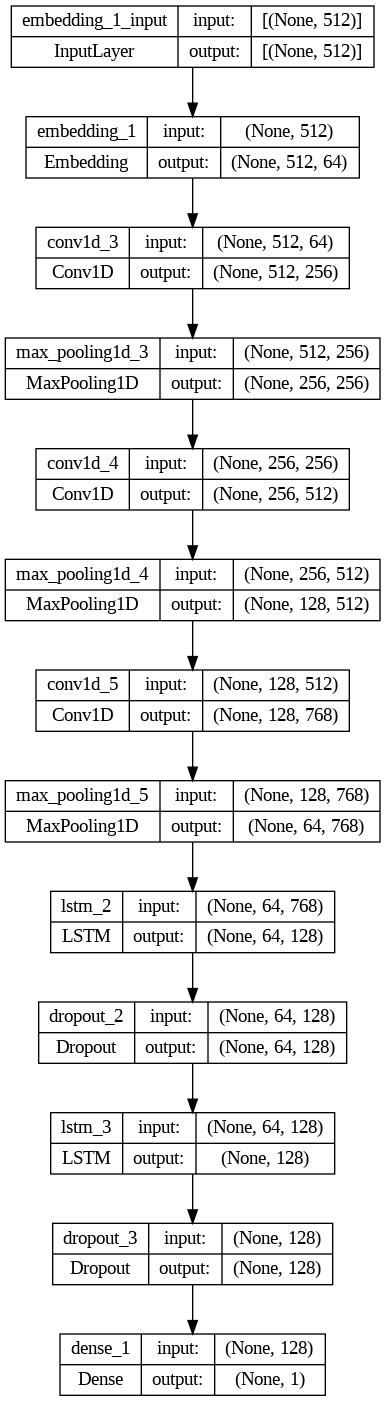

In [58]:
from keras.utils.vis_utils import plot_model
plot_model(
    lstm_classifier.model,
    to_file="recurrent_conv_net.png",
    show_shapes=True,
    show_layer_names=True)

In [59]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = lstm_classifier.predict(X_valid)
#print(y_pred)
print(confusion_matrix(y_valid, y_pred > 0.5))
print(classification_report(y_valid, y_pred > 0.5))

324/324 [==============================] - 232s 712ms/step
[[4963  158]
 [ 298 4943]]
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      5121
           1       0.97      0.94      0.96      5241

    accuracy                           0.96     10362
   macro avg       0.96      0.96      0.96     10362
weighted avg       0.96      0.96      0.96     10362



## Testing Results

In [60]:
from sklearn.metrics import accuracy_score

y_pred_test = lstm_classifier.predict(X_test)
print(classification_report(y_test, y_pred_test > 0.5))

694/694 [==============================] - 483s 697ms/step
              precision    recall  f1-score   support

           0       0.95      0.96      0.95     11143
           1       0.96      0.94      0.95     11061

    accuracy                           0.95     22204
   macro avg       0.95      0.95      0.95     22204
weighted avg       0.95      0.95      0.95     22204

